In [1]:
import os
import gc
import math

# numpy
import numpy as np
import numpy.ma as ma

from jax import vmap, grad, jit, random
from jax.config import config
# from jax.experimental import optimizers
import jax.numpy as jnp
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

config.update("jax_enable_x64", True)

# from skimage.restoration import estimate_sigma
from skimage.transform import resize

### CRPS
import properscoring as ps

### SSIM and PSNR
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage import filters

# plotting
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')

from matplotlib.gridspec import GridSpec
from matplotlib import colors
from cartopy import config
import cartopy.crs as ccrs

# netCDF
import netCDF4 as nc

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import pickle

In [2]:
xhist_tas = pickle.load(open('../data/saved/xhist_tas.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/saved/xrcp_tas.pkl', 'rb'))

xhist_pr = pickle.load(open('../data/saved/xhist_pr.pkl', 'rb'))
xrcp_pr = pickle.load(open('../data/saved/xrcp_pr.pkl', 'rb'))

In [3]:
nval = 72
nmod = len(xhist_tas)

In [4]:
sgpr_tas = [np.load(f'tas_predictions/sgpr_tas_{m}.npz.npy') for m in trange(nmod)]
gpse_tas = [np.load(f'tas_predictions/gpr_se_tas_{m}.npz.npy') for m in trange(nmod)]
gpex_tas = [np.load(f'tas_predictions/gpr_exp_tas_{m}.npz.npy') for m in trange(nmod)]

sgpr_pr = [np.load(f'pr_predictions/sgpr_pr_{m}.npz.npy') for m in trange(nmod)]
gpse_pr = [np.load(f'pr_predictions/gpr_se_pr_{m}.npz.npy') for m in trange(nmod)]
gpex_pr = [np.load(f'pr_predictions/gpr_exp_pr_{m}.npz.npy') for m in trange(nmod)]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [6]:
ntest = sgpr_tas[0].shape[0] + nval

In [7]:
months = 12 * 10
decades = int((ntest-nval)/(months))

In [8]:
sgpr_mse_tas = np.zeros((decades, nmod))
gpse_mse_tas = np.zeros((decades, nmod))
gpex_mse_tas = np.zeros((decades, nmod))

sgpr_mse_pr = np.zeros((decades, nmod))
gpse_mse_pr = np.zeros((decades, nmod))
gpex_mse_pr = np.zeros((decades, nmod))

sgpr_ssim_tas = np.zeros((decades, nmod))
gpse_ssim_tas = np.zeros((decades, nmod))
gpex_ssim_tas = np.zeros((decades, nmod))

sgpr_ssim_pr = np.zeros((decades, nmod))
gpse_ssim_pr = np.zeros((decades, nmod))
gpex_ssim_pr = np.zeros((decades, nmod))

for m1 in trange(nmod):
    ytest_tas = np.array(xrcp_tas[m1])[nval:ntest]
    ytest_pr = np.array(xrcp_pr[m1])[nval:ntest]
    
    nlat = ytest_tas.shape[1]
    scale = np.cos(np.linspace(math.pi/2, -math.pi/2, nlat))
    
    for d in range(decades):
        
        ytest_dec = ytest_tas[(months*d):(months*(d+1))].astype('float32') * scale[None,:,None]
        
        sgpr_dec = sgpr_tas[m1][(months*d):(months*(d+1))].astype('float32') * scale[None,:,None]
        gpse_dec = gpse_tas[m1][(months*d):(months*(d+1))].astype('float32') * scale[None,:,None]
        gpex_dec = gpex_tas[m1][(months*d):(months*(d+1))].astype('float32') * scale[None,:,None]
        
        sgpr_mse_tas[d, m1] = np.mean((sgpr_dec - ytest_dec)**2)
        gpse_mse_tas[d, m1] = np.mean((gpse_dec - ytest_dec)**2)
        gpex_mse_tas[d, m1] = np.mean((gpex_dec - ytest_dec)**2)
        
        sgpr_ssim_tas[d, m1] = ssim(sgpr_dec, ytest_dec)
        gpse_ssim_tas[d, m1] = ssim(gpse_dec, ytest_dec)
        gpex_ssim_tas[d, m1] = ssim(gpex_dec, ytest_dec)

        ytest_dec = ytest_pr[(months*d):(months*(d+1))].astype('float32') * scale[None,:,None]

        sgpr_dec = sgpr_pr[m1][(months*d):(months*(d+1))].astype('float32') * scale[None,:,None]
        gpse_dec = gpse_pr[m1][(months*d):(months*(d+1))].astype('float32') * scale[None,:,None]
        gpex_dec = gpex_pr[m1][(months*d):(months*(d+1))].astype('float32') * scale[None,:,None]
        
        sgpr_mse_pr[d, m1] = np.mean((sgpr_dec - ytest_dec)**2)
        gpse_mse_pr[d, m1] = np.mean((gpse_dec - ytest_dec)**2)
        gpex_mse_pr[d, m1] = np.mean((gpex_dec - ytest_dec)**2)
        
        sgpr_ssim_pr[d, m1] = ssim(sgpr_dec, ytest_dec)
        gpse_ssim_pr[d, m1] = ssim(gpse_dec, ytest_dec)
        gpex_ssim_pr[d, m1] = ssim(gpex_dec, ytest_dec)

  0%|          | 0/16 [00:00<?, ?it/s]

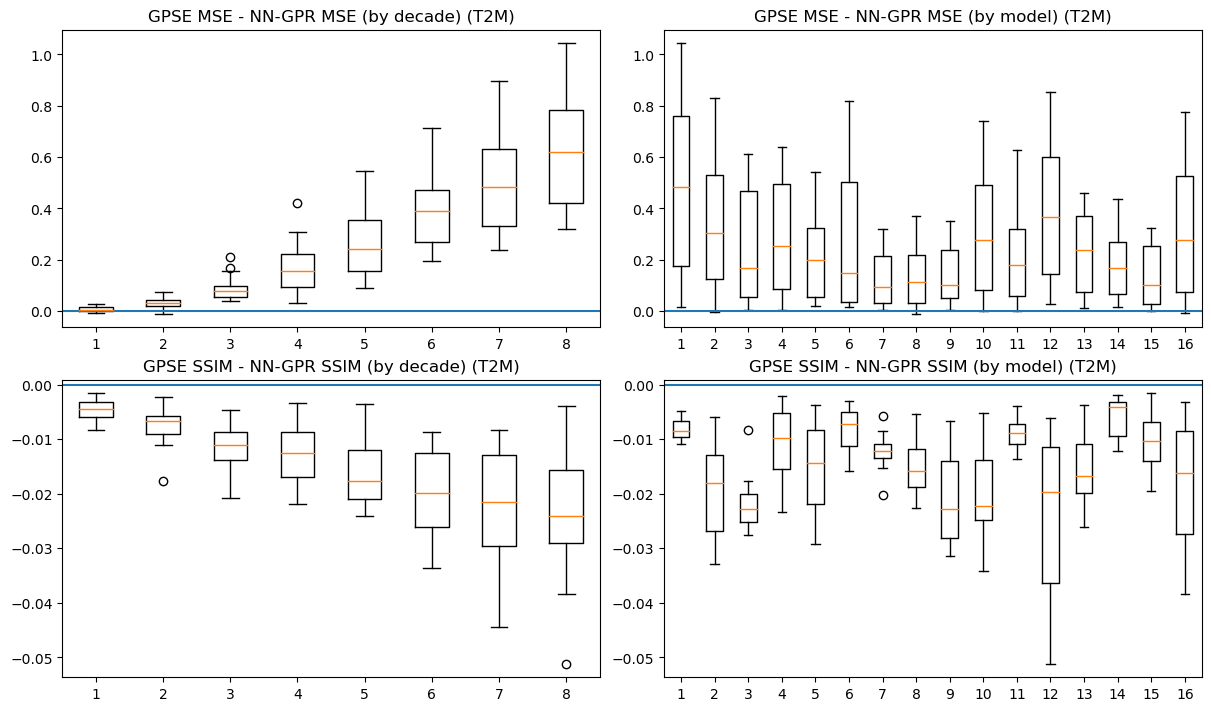

In [9]:
fig, ax = plt.subplots(2, 2, figsize = (12, 7), constrained_layout = True)

ax[0, 0].boxplot(gpse_mse_tas.T - sgpr_mse_tas.T)
ax[0, 0].axhline(0)
ax[0, 0].set_title('GPSE MSE - NN-GPR MSE (by decade) (T2M)')
ax[0, 1].boxplot(gpse_mse_tas - sgpr_mse_tas)
ax[0, 1].axhline(0)
ax[0, 1].set_title('GPSE MSE - NN-GPR MSE (by model) (T2M)')

ax[1, 0].boxplot(gpse_ssim_tas.T - sgpr_ssim_tas.T)
ax[1, 0].axhline(0)
ax[1, 0].set_title('GPSE SSIM - NN-GPR SSIM (by decade) (T2M)')
ax[1, 1].boxplot(gpse_ssim_tas - sgpr_ssim_tas)
ax[1, 1].axhline(0)
ax[1, 1].set_title('GPSE SSIM - NN-GPR SSIM (by model) (T2M)')
plt.show()

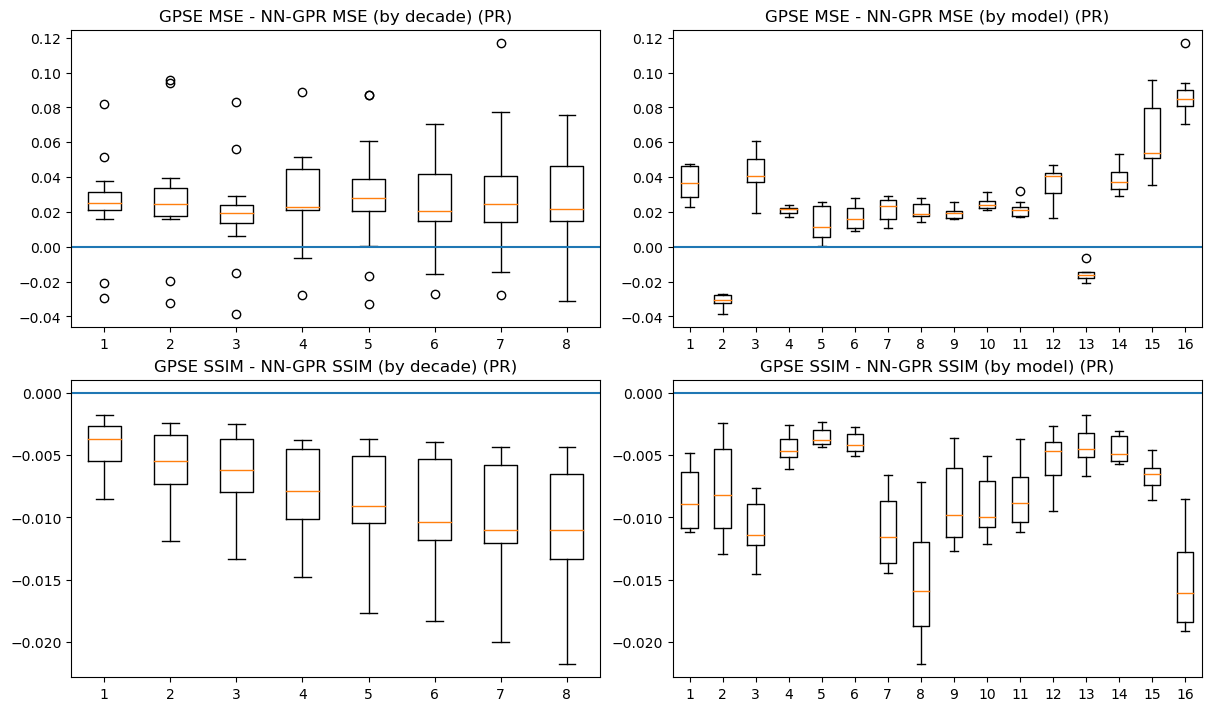

In [10]:
fig, ax = plt.subplots(2, 2, figsize = (12, 7), constrained_layout = True)

ax[0, 0].boxplot(gpse_mse_pr.T - sgpr_mse_pr.T)
ax[0, 0].axhline(0)
ax[0, 0].set_title('GPSE MSE - NN-GPR MSE (by decade) (PR)')
ax[0, 1].boxplot(gpse_mse_pr - sgpr_mse_pr)
ax[0, 1].axhline(0)
ax[0, 1].set_title('GPSE MSE - NN-GPR MSE (by model) (PR)')

ax[1, 0].boxplot(gpse_ssim_pr.T - sgpr_ssim_pr.T)
ax[1, 0].axhline(0)
ax[1, 0].set_title('GPSE SSIM - NN-GPR SSIM (by decade) (PR)')
ax[1, 1].boxplot(gpse_ssim_pr - sgpr_ssim_pr)
ax[1, 1].axhline(0)
ax[1, 1].set_title('GPSE SSIM - NN-GPR SSIM (by model) (PR)')
plt.show()

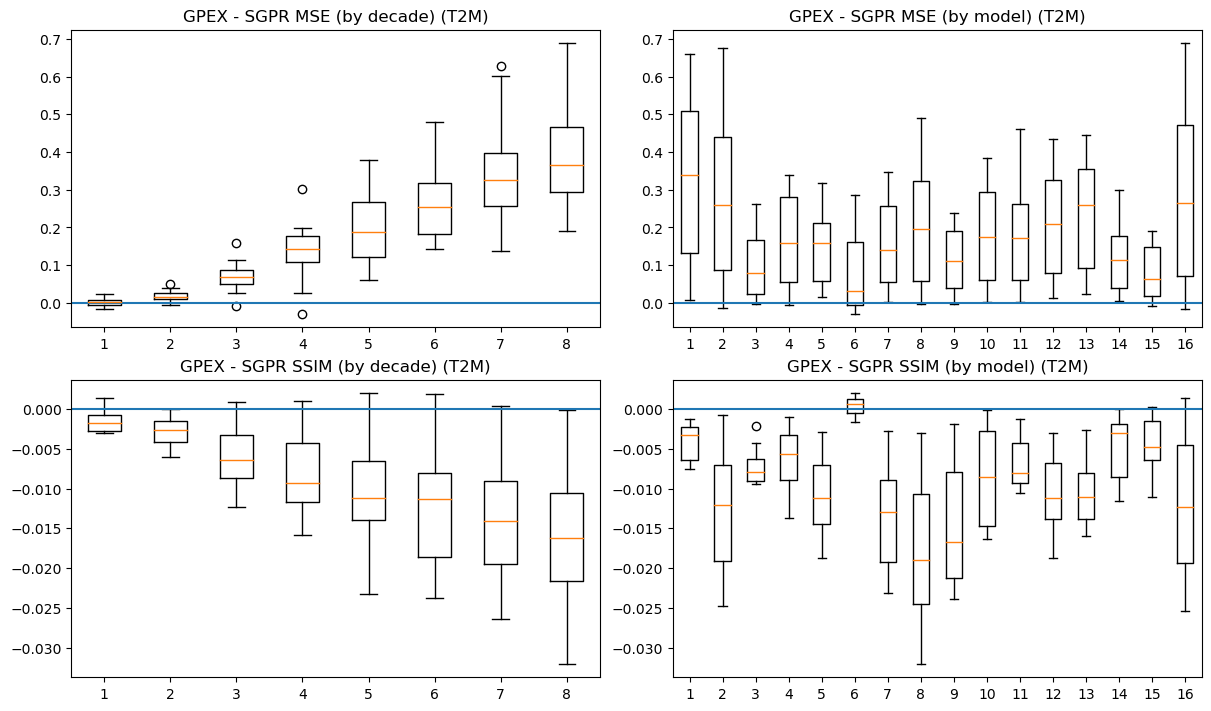

In [15]:
fig, ax = plt.subplots(2, 2, figsize = (12, 7), constrained_layout = True)

ax[0, 0].boxplot(gpex_mse_tas.T - sgpr_mse_tas.T)
ax[0, 0].axhline(0)
ax[0, 0].set_title('GPEX - SGPR MSE (by decade) (T2M)')
ax[0, 1].boxplot(gpex_mse_tas - sgpr_mse_tas)
ax[0, 1].axhline(0)
ax[0, 1].set_title('GPEX - SGPR MSE (by model) (T2M)')

ax[1, 0].boxplot(gpex_ssim_tas.T - sgpr_ssim_tas.T)
ax[1, 0].axhline(0)
ax[1, 0].set_title('GPEX - SGPR SSIM (by decade) (T2M)')
ax[1, 1].boxplot(gpex_ssim_tas - sgpr_ssim_tas)
ax[1, 1].axhline(0)
ax[1, 1].set_title('GPEX - SGPR SSIM (by model) (T2M)')
plt.show()

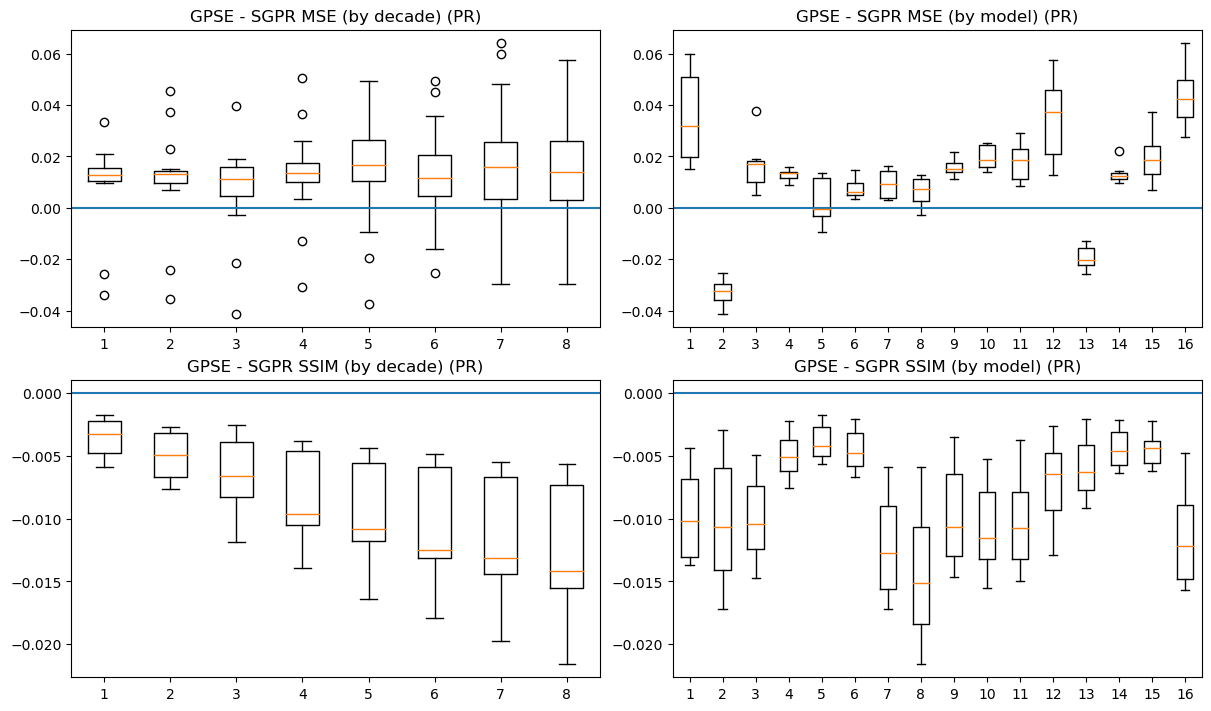

In [16]:
fig, ax = plt.subplots(2, 2, figsize = (12, 7), constrained_layout = True)

ax[0, 0].boxplot(gpex_mse_pr.T - sgpr_mse_pr.T)
ax[0, 0].axhline(0)
ax[0, 0].set_title('GPSE - SGPR MSE (by decade) (PR)')
ax[0, 1].boxplot(gpex_mse_pr - sgpr_mse_pr)
ax[0, 1].axhline(0)
ax[0, 1].set_title('GPSE - SGPR MSE (by model) (PR)')

ax[1, 0].boxplot(gpex_ssim_pr.T - sgpr_ssim_pr.T)
ax[1, 0].axhline(0)
ax[1, 0].set_title('GPSE - SGPR SSIM (by decade) (PR)')
ax[1, 1].boxplot(gpex_ssim_pr - sgpr_ssim_pr)
ax[1, 1].axhline(0)
ax[1, 1].set_title('GPSE - SGPR SSIM (by model) (PR)')
plt.show()